In [88]:
import numpy as np
from matplotlib import pyplot as plt

In [89]:
#define constants
n = 64
os = 1
osigma2 = 1

#load data
train = np.loadtxt('hw6_q2_train.csv', delimiter=",", dtype=float)
test = np.loadtxt('hw6_q2_test.csv', delimiter=",", dtype=float)

In [90]:
#function that computes kernel
def kernel(x,xp,s):
    k = np.e**(-(1 / (2 * s**2)) * (x - xp)**2)
    return k

#define a function to "fill" a matrix with kernel values to make life easier, only works for vector size of 1
def mkernel(x,xp,s):
    
    x1v, x2v = np.meshgrid(x,xp)
    
    k = kernel(x1v,x2v,s)
    
    return k.T

#function that computes kernels for GPR
def gpr(x_train, x_test, y_train, s, sigma_2):
    mean = mkernel(x_train, x_test, s).T @ np.linalg.inv(mkernel(x_train,x_train,s) 
                                                         + sigma_2 * np.eye(len(x_train))) @ (y_train - 0)
    covariance = mkernel(x_test, x_test, s) - mkernel(x_train, x_test, s).T @ np.linalg.inv(mkernel(x_train, x_train, s) 
                                                                                            + sigma_2 * np.eye(len(x_train))) @ mkernel(x_train, x_test, s)
    return mean, covariance

In [91]:
#split training data into x and y 
x_train = train[:,0]
y_train = train[:,1]

#split testing data into x and y
x_test = test[:,0]
y_test = test[:,1]

In [92]:
#compute predictions
x_values = np.linspace(-5,5,100)
mean, covariance = gpr(x_train, x_values, y_train, os, osigma2)

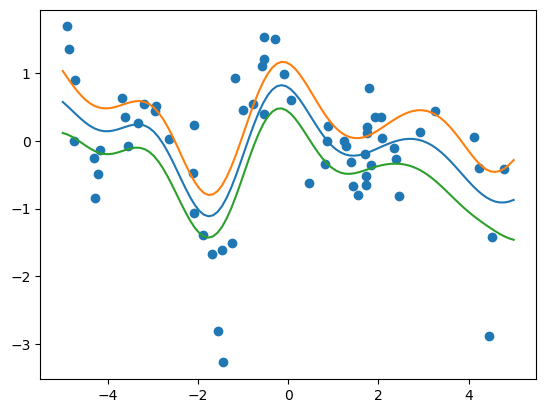

In [93]:
plt.scatter(x_train, y_train) 
plt.plot(x_values, mean)
plt.plot(x_values, mean + np.sqrt(np.diag(covariance)))
plt.plot(x_values, mean - np.sqrt(np.diag(covariance)))

In [95]:
def NLL(x, y, s, sigma2):
    n = np.size(x)
    C = mkernel(x, x, s) + sigma2 * np.identity(n)
    lp = (1 / 2) * y.T @ np.linalg.inv(C) @ y + np.log(np.det(C)) + n * np.log(2 * np.pi())
    return lp

def grad_NLL(x, y, s, sigma2):
    n = np.size(x)
    C = mkernel(x, x, s) + sigma2 * np.identity(n)
    dC_ds = (x2v - x1v) * C / s**3
    dC_sigma2 = np.identity(n)
    
    C_inv = np.linalg.inv(C)
    alpha = C_inv @ y
    
    d_s = 1 / 2 * np.trace(C_inv @ dC_ds) - 1 / 2 * alpha.T @ dC_ds @ alpha
    d_sigma2 = 1 / 2 * np.trace(C_inv @ dC_sigma2) - alpha.T @ dC_sigma2 @ alpha
    
    return d_s, d_sigma2